In [53]:
import os
import numpy as np
import pandas as pd
import math
import random
from datetime import datetime
import pickle
from utils import pkl_load, pad_nan_to_target
from scipy.io.arff import loadarff
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def load_UCR(dataset):
    train_file = os.path.join('datasets/UCR', dataset, dataset + "_TRAIN.tsv")
    test_file = os.path.join('datasets/UCR', dataset, dataset + "_TEST.tsv")
    train_df = pd.read_csv(train_file, sep='\t', header=None)
    test_df = pd.read_csv(test_file, sep='\t', header=None)
    train_array = np.array(train_df)
    test_array = np.array(test_df)

    # Move the labels to {0, ..., L-1}
    labels = np.unique(train_array[:, 0])
    transform = {}
    for i, l in enumerate(labels):
        transform[l] = i

    train = train_array[:, 1:].astype(np.float64)
    train_labels = np.vectorize(transform.get)(train_array[:, 0])
    test = test_array[:, 1:].astype(np.float64)
    test_labels = np.vectorize(transform.get)(test_array[:, 0])

    # Normalization for non-normalized datasets
    # To keep the amplitude information, we do not normalize values over
    # individual time series, but on the whole dataset
    if dataset not in [
        'AllGestureWiimoteX',
        'AllGestureWiimoteY',
        'AllGestureWiimoteZ',
        'BME',
        'Chinatown',
        'Crop',
        'EOGHorizontalSignal',
        'EOGVerticalSignal',
        'Fungi',
        'GestureMidAirD1',
        'GestureMidAirD2',
        'GestureMidAirD3',
        'GesturePebbleZ1',
        'GesturePebbleZ2',
        'GunPointAgeSpan',
        'GunPointMaleVersusFemale',
        'GunPointOldVersusYoung',
        'HouseTwenty',
        'InsectEPGRegularTrain',
        'InsectEPGSmallTrain',
        'MelbournePedestrian',
        'PickupGestureWiimoteZ',
        'PigAirwayPressure',
        'PigArtPressure',
        'PigCVP',
        'PLAID',
        'PowerCons',
        'Rock',
        'SemgHandGenderCh2',
        'SemgHandMovementCh2',
        'SemgHandSubjectCh2',
        'ShakeGestureWiimoteZ',
        'SmoothSubspace',
        'UMD'
    ]:
        return train[..., np.newaxis], train_labels, test[..., np.newaxis], test_labels
    
    mean = np.nanmean(train)
    std = np.nanstd(train)
    train = (train - mean) / std
    test = (test - mean) / std
    return train[..., np.newaxis], train_labels, test[..., np.newaxis], test_labels


def load_UEA(dataset):
    train_data = loadarff(f'datasets/UEA/{dataset}/{dataset}_TRAIN.arff')[0]
    test_data = loadarff(f'datasets/UEA/{dataset}/{dataset}_TEST.arff')[0]
    
    def extract_data(data):
        res_data = []
        res_labels = []
        for t_data, t_label in data:
            t_data = np.array([ d.tolist() for d in t_data ])
            t_label = t_label.decode("utf-8")
            res_data.append(t_data)
            res_labels.append(t_label)
        return np.array(res_data).swapaxes(1, 2), np.array(res_labels)
    
    train_X, train_y = extract_data(train_data)
    test_X, test_y = extract_data(test_data)
    
    scaler = StandardScaler()
    scaler.fit(train_X.reshape(-1, train_X.shape[-1]))
    train_X = scaler.transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
    test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
    
    labels = np.unique(train_y)
    transform = { k : i for i, k in enumerate(labels)}
    train_y = np.vectorize(transform.get)(train_y)
    test_y = np.vectorize(transform.get)(test_y)
    return train_X, train_y, test_X, test_y
    
    
def load_forecast_npy(name, univar=False):
    data = np.load(f'datasets/{name}.npy')    
    if univar:
        data = data[: -1:]
        
    train_slice = slice(None, int(0.6 * len(data)))
    valid_slice = slice(int(0.6 * len(data)), int(0.8 * len(data)))
    test_slice = slice(int(0.8 * len(data)), None)
    
    scaler = StandardScaler().fit(data[train_slice])
    data = scaler.transform(data)
    data = np.expand_dims(data, 0)

    pred_lens = [24, 48, 96, 288, 672]
    return data, train_slice, valid_slice, test_slice, scaler, pred_lens, 0


def _get_time_features(dt):
    return np.stack([
        dt.minute.to_numpy(),
        dt.hour.to_numpy(),
        dt.dayofweek.to_numpy(),
        dt.day.to_numpy(),
        dt.dayofyear.to_numpy(),
        dt.month.to_numpy(),
        dt.weekofyear.to_numpy(),
    ], axis=1).astype(np.float)

def load_anomaly(name):
    res = pkl_load(f'datasets/{name}.pkl')
    return res['all_train_data'], res['all_train_labels'], res['all_train_timestamps'], \
           res['all_test_data'],  res['all_test_labels'],  res['all_test_timestamps'], \
           res['delay']


def gen_ano_train_data(all_train_data):
    maxl = np.max([ len(all_train_data[k]) for k in all_train_data ])
    pretrain_data = []
    for k in all_train_data:
        train_data = pad_nan_to_target(all_train_data[k], maxl, axis=0)
        pretrain_data.append(train_data)
    pretrain_data = np.expand_dims(np.stack(pretrain_data), 2)
    return pretrain_data

    
    

def load_forecast_csv(name, univar=False):
    data = pd.read_csv(f'datasets/{name}.csv', index_col='date', parse_dates=True)
    dt_embed = _get_time_features(data.index)  # 设置日期特征
    n_covariate_cols = dt_embed.shape[-1]  # 日期特征数量
    
    if univar:  # 对变量时间序列
        if name in ('ETTh1', 'ETTh2', 'ETTm1', 'ETTm2'):
            data = data[['OT']]
        elif name == 'electricity':
            data = data[['MT_001']]
        else:
            data = data.iloc[:, -1:]  # 1 column dataframe
        
    data = data.to_numpy()
    if name == 'ETTh1' or name == 'ETTh2':
        train_slice = slice(None, 12*30*24)
        valid_slice = slice(12*30*24, 16*30*24)
        test_slice = slice(16*30*24, 20*30*24)
    elif name == 'ETTm1' or name == 'ETTm2':
        train_slice = slice(None, 12*30*24*4)
        valid_slice = slice(12*30*24*4, 16*30*24*4)
        test_slice = slice(16*30*24*4, 20*30*24*4)
    else:
        train_slice = slice(None, int(0.6 * len(data)))
        valid_slice = slice(int(0.6 * len(data)), int(0.8 * len(data)))
        test_slice = slice(int(0.8 * len(data)), None)
    
    scaler = StandardScaler().fit(data[train_slice])
    data = scaler.transform(data)
    if name in ('electricity'):
        data = np.expand_dims(data.T, -1)  # Each variable is an instance rather than a feature
    else:
        data = np.expand_dims(data, 0)
    
    if n_covariate_cols > 0:
        dt_scaler = StandardScaler().fit(dt_embed[train_slice])
        dt_embed = np.expand_dims(dt_scaler.transform(dt_embed), 0)
        data = np.concatenate([np.repeat(dt_embed, data.shape[0], axis=0), data], axis=-1)
    
    if name in ('ETTh1', 'ETTh2', 'electricity'):
        pred_lens = [24, 48, 168, 336, 720]
    else:
        pred_lens = [24, 48, 96, 288, 672]
        
    return data, train_slice, valid_slice, test_slice, scaler, pred_lens, n_covariate_cols



def load_forecast_parquet(file_path):
    """
    load file then normalize it and date feature
    """
    file_path = r'datasets/Astock_daily_2011_2022.h5'
    data = pd.read_parquet(file_path)
    # 添加时间特征
    dt_embed_2d = _get_time_features(pd.to_datetime(data.reset_index().date.values))  ## 需要改成三维的
    scaler = StandardScaler().fit(data[:int(data.shape[0]*0.6)])  # 计算zscore的scaler
    # 特征标准化
    scaler = StandardScaler().fit(data[:int(data.shape[0]*0.6)])  # 计算zscore的scaler
#     dt_scaler = StandardScaler().fit(dt_embed[:int(dt_embed_2d.shape[0]*0.6)])
    # 维度变换
    data = data.to_xarray().to_array(dim='factor')  # DataArray Type
    data = data.transpose('code','date','factor')  # 维度位置变换
    data = data.reshape(data.shape[0]*data.shape[1], data.shape[2])
    date_length = data.shape[1]  # 数据时间维度长度
    # 数据集划分
    train_slice = slice(None, int(0.6 * date_length))
    valid_slice = slice(int(0.6 * date_length), int(0.8 * date_length))
    test_slice = slice(int(0.8 * date_length), None)
    # 数据合并
    data_2dim = data.values.reshape(data.shape[0]*data.shape[1], data.shape[2])
    data_2dim = scaler.transform(data_2dim) # 特征标准化
    data.values = data_2dim.reshape(data.shape[0], data.shape[1], data.shape[2])  # data数值做了标准化
    ## date process
    dt_embed = _get_time_features(pd.to_datetime(data.date.values))
    dt_scaler = StandardScaler().fit(dt_embed[train_slice])
    
    
#     scaler = StandardScaler().fit(data)

In [211]:
sl = slice(None, 1000)

In [217]:
_get_time_features(pd.to_datetime(data.date.values[sl]))[train_slice].shape

D:\Program Files (x86)\Anaconda\envs\py37\lib\site-packages\ipykernel_launcher.py:133: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


(1000, 7)

In [209]:
pd.to_datetime(data.date.values)

DatetimeIndex(['2011-01-04', '2011-01-05', '2011-01-06', '2011-01-07',
               '2011-01-10', '2011-01-11', '2011-01-12', '2011-01-13',
               '2011-01-14', '2011-01-17',
               ...
               '2022-03-21', '2022-03-22', '2022-03-23', '2022-03-24',
               '2022-03-25', '2022-03-28', '2022-03-29', '2022-03-30',
               '2022-03-31', '2022-04-01'],
              dtype='datetime64[ns]', length=2734, freq=None)

In [206]:
data

<xarray.DataArray (factor: 2734, date: 16, code: 4358)>
array([[[3.35660000e+00, 9.12410000e+00,            nan, ...,
                    nan,            nan,            nan],
        [1.37330000e+00, 3.97730000e+00,            nan, ...,
                    nan,            nan,            nan],
        [2.38540000e+00, 3.28430000e+00,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [4.95980000e+00, 6.75680000e+00,            nan, ...,
                    nan,            nan,            nan],
        [1.65020000e+00, 5.84730000e+00,            nan, ...,
                    nan,            nan,            nan],
        [1.59470000e+00, 3.55030000e+00,            nan, ...,
                    nan,            nan,            nan]],

       [[1.12060000e+00, 2.35570000e+00,            nan, ...,
                    nan,            nan,            nan],
        [2.62120000e+00, 4.46530000e+00,            nan, ...,
                    nan,            nan,            nan],
        [1.95690000e+00, 4.81930000e+00,            nan, ...,
                    nan,            nan,            nan],
...
        [1.00303269e+08, 1.58372769e+08, 4.87428000e+06, ...,
         8.35512000e+05, 1.50437050e+07, 2.47591400e+06],
        [1.80076017e+08, 2.29964748e+08, 6.52017800e+06, ...,
         9.38673000e+05, 2.87564570e+07, 1.90656200e+06],
        [2.24915816e+08, 1.05907867e+08, 5.54830000e+06, ...,
         7.57983000e+05, 1.83784130e+07, 2.97751600e+06]],

       [[1.49364697e+08, 1.02124839e+08, 5.45273200e+06, ...,
         6.92338000e+05, 2.09128170e+07, 2.48777200e+06],
        [1.11840734e+08, 1.12594520e+08, 4.55216000e+06, ...,
         4.48991000e+05, 1.56231250e+07, 2.21604600e+06],
        [1.78140887e+08, 2.09884233e+08, 4.03663600e+06, ...,
         7.47913000e+05, 2.90633890e+07, 4.60842100e+06],
        ...,
        [1.23679155e+08, 2.19506404e+08, 5.45908800e+06, ...,
         3.78039000e+05, 9.15502500e+06, 1.29279100e+06],
        [1.16374674e+08, 3.34939975e+08, 4.75760300e+06, ...,
         3.21309000e+05, 1.27303070e+07, 4.13741000e+05],
        [1.48487874e+08, 3.01454185e+08, 3.81080000e+06, ...,
         4.67876000e+05, 1.19426370e+07, 9.98430000e+05]]])
Coordinates:
  * date     (date) datetime64[ns] 2011-01-04 2011-01-05 ... 2022-04-01
  * code     (code) object '000001.SZ' '000002.SZ' ... '688981.SH' '689009.SH'
  * factor   (factor) <U13 'amp_rate' 'avg_price' ... 'turnover_rate' 'volume'

In [180]:
data = data_a.to_xarray().to_array(dim='factor')

In [193]:
data.shape

(16, 2734, 4358)

In [191]:
a= data.values.reshape(data.shape[0]*data.shape[1],data.shape[2])#.reshape(data.shape[1],data.shape[1],16)

In [185]:
data.values.reshape(data.shape[0]*data.shape[1],data.shape[2])

array([[3.35660000e+00, 9.12410000e+00,            nan, ...,
                   nan,            nan,            nan],
       [1.37330000e+00, 3.97730000e+00,            nan, ...,
                   nan,            nan,            nan],
       [2.38540000e+00, 3.28430000e+00,            nan, ...,
                   nan,            nan,            nan],
       ...,
       [1.23679155e+08, 2.19506404e+08, 5.45908800e+06, ...,
        3.78039000e+05, 9.15502500e+06, 1.29279100e+06],
       [1.16374674e+08, 3.34939975e+08, 4.75760300e+06, ...,
        3.21309000e+05, 1.27303070e+07, 4.13741000e+05],
       [1.48487874e+08, 3.01454185e+08, 3.81080000e+06, ...,
        4.67876000e+05, 1.19426370e+07, 9.98430000e+05]])

In [164]:
data.values.reshape([11914772,data.shape[2]])

IndexError: tuple index out of range

In [166]:
len(data.values.flatten())

190636352

In [174]:
len(data.values.flatten())

190636352

In [167]:
4358*2734*data.shape[2]

IndexError: tuple index out of range

In [156]:
data.shape


(4358, 2734, 16)

In [152]:
scaler.transform(data.values[0,:,:])

array([[-0.11082871, -0.05119986, -0.0487484 , ...,  1.05506794,
        -0.36023069,  0.66899467],
       [-0.85291645, -0.05004006, -0.05415423, ...,  0.57115654,
        -0.45817985,  0.32951962],
       [-0.47422084, -0.05946263, -0.06136202, ...,  0.43929475,
        -0.48314336,  0.24300949],
       ...,
       [-0.06686395, -0.10780134, -0.09740093, ...,  4.27224554,
        -0.49011108,  3.12448486],
       [-0.11213829, -0.08744187, -0.08718991, ...,  4.09614602,
        -0.49953505,  2.92019006],
       [ 0.06862235, -0.07259893, -0.06496591, ...,  5.4227795 ,
        -0.45805454,  3.81834557]])

In [151]:
scaler = StandardScaler().fit(data_a[:int(data_a.shape[0]*0.6)])  # 计算zscore的scaler

In [150]:
data_a

amp_rate  avg_price  close    factor   high  high_limit  \
date       code                                                                 
2011-01-04 000001.SZ    3.3566    15.9777  16.02   37.4475  16.18       17.37   
           000002.SZ    9.1241     8.7157   8.80  107.6908   8.98        9.04   
           000005.SZ    3.5422     3.7489   3.75   17.5065   3.79        4.04   
           000006.SZ    7.0301     7.2354   7.27   25.3296   7.45        7.67   
           000009.SZ    3.8760    16.9570  16.94    3.4122  17.21       18.45   
...                        ...        ...    ...       ...    ...         ...   
2022-04-01 688599.SH    5.5008    59.7654  59.90    1.0158  61.37       70.68   
           688600.SH    2.1306    14.3109  14.30    1.0154  14.55       17.46   
           688788.SH    3.3117    75.7040  75.96    1.0057  77.07       92.40   
           688981.SH    1.5405    45.6784  45.71    1.0000  46.02       55.31   
           689009.SH    3.2884    43.2510  43.39    1.0000  44.15       48.17   

                      is_paused  is_st    low  low_limit   open  prev_close  \
date       code                                                               
2011-01-04 000001.SZ        0.0    0.0  15.65      14.21  15.82       15.79   
           000002.SZ        0.0    0.0   8.23       7.40   8.27        8.22   
           000005.SZ        0.0    0.0   3.66       3.30   3.68        3.67   
           000006.SZ        0.0    0.0   6.96       6.27   7.05        6.97   
           000009.SZ        0.0    0.0  16.56      15.09  16.78       16.77   
...                         ...    ...    ...        ...    ...         ...   
2022-04-01 688599.SH        0.0    0.0  58.13      47.12  58.30       58.90   
           688600.SH        0.0    0.0  14.24      11.64  14.55       14.55   
           688788.SH        0.0    0.0  74.52      61.60  77.01       77.00   
           688981.SH        0.0    0.0  45.31      36.87  45.88       46.09   
           689009.SH        0.0    0.0  42.71      39.41  43.79       43.79   

                      close_rate      turnover  turnover_rate       volume  
date       code                                                             
2011-01-04 000001.SZ      1.4566  5.733437e+08         1.1555   35884061.0  
           000002.SZ      7.0560  1.645667e+09         1.9554  188816123.0  
           000005.SZ      2.1798  4.172098e+07         1.2179   11128834.0  
           000006.SZ      4.3042  1.199381e+08         2.2373   16576602.0  
           000009.SZ      1.0137  2.901755e+08         1.5952   17112464.0  
...                          ...           ...            ...          ...  
2022-04-01 688599.SH      1.6978  1.113603e+09         1.4480   18632913.0  
           688600.SH     -1.7182  5.506018e+06         0.5766     384743.0  
           688788.SH     -1.3506  3.542010e+07         1.4095     467876.0  
           688981.SH     -0.8245  5.455204e+08         0.6383   11942637.0  
           689009.SH     -0.9135  4.318313e+07         0.1962     998430.0  

[8157488 rows x 16 columns]

In [132]:
data_a.unstack()

<xarray.DataArray (dim_1: 16, date: 2734, code: 4358)>
array([[[3.35660000e+00, 9.12410000e+00,            nan, ...,
                    nan,            nan,            nan],
        [1.37330000e+00, 3.97730000e+00,            nan, ...,
                    nan,            nan,            nan],
        [2.38540000e+00, 3.28430000e+00,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [3.47410000e+00, 9.03890000e+00, 4.41390000e+00, ...,
         2.35820000e+00, 9.74900000e-01, 3.61340000e+00],
        [3.35310000e+00, 9.85250000e+00, 2.42950000e+00, ...,
         2.23480000e+00, 1.95280000e+00, 2.47170000e+00],
        [3.83620000e+00, 1.07572000e+01, 3.04850000e+00, ...,
         3.31170000e+00, 1.54050000e+00, 3.28840000e+00]],

       [[1.59777000e+01, 8.71570000e+00,            nan, ...,
                    nan,            nan,            nan],
        [1.59970000e+01, 8.85840000e+00,            nan, ...,
                    nan,            nan,            nan],
        [1.58402000e+01, 8.84890000e+00,            nan, ...,
                    nan,            nan,            nan],
...
        [6.37300000e-01, 2.25890000e+00, 4.69270000e+00, ...,
         1.13890000e+00, 4.89300000e-01, 2.65700000e-01],
        [5.99700000e-01, 3.44680000e+00, 4.08970000e+00, ...,
         9.67900000e-01, 6.80400000e-01, 8.13000000e-02],
        [7.65200000e-01, 3.10220000e+00, 3.27580000e+00, ...,
         1.40950000e+00, 6.38300000e-01, 1.96200000e-01]],

       [[3.58840610e+07, 1.88816123e+08,            nan, ...,
                    nan,            nan,            nan],
        [2.37462630e+07, 1.25616280e+08,            nan, ...,
                    nan,            nan,            nan],
        [2.06531270e+07, 7.91284460e+07,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [1.23679155e+08, 2.19506404e+08, 5.45908800e+06, ...,
         3.78039000e+05, 9.15502500e+06, 1.29279100e+06],
        [1.16374674e+08, 3.34939975e+08, 4.75760300e+06, ...,
         3.21309000e+05, 1.27303070e+07, 4.13741000e+05],
        [1.48487874e+08, 3.01454185e+08, 3.81080000e+06, ...,
         4.67876000e+05, 1.19426370e+07, 9.98430000e+05]]])
Coordinates:
  * dim_1    (dim_1) object 'amp_rate' 'avg_price' ... 'turnover_rate' 'volume'
  * date     (date) datetime64[ns] 2011-01-04 2011-01-05 ... 2022-04-01
  * code     (code) object '000001.SZ' '000002.SZ' ... '688981.SH' '689009.SH'

In [112]:
b = StandardScaler().fit(data_a)

In [103]:
data = data.transpose('code','date','holcv')  # 维度位置变换

In [113]:
b.transform(data.values[3,:,:])

array([[-0.08117392, -0.47610773, -0.4758661 , ..., -0.29560505,
        -0.35597912, -0.07167361],
       [-0.50623485, -0.4763938 , -0.4758661 , ..., -0.32750356,
        -0.4565648 , -0.17087564],
       [-0.80394868, -0.47517799, -0.4755257 , ..., -0.33524543,
        -0.48283049, -0.19676767],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

In [99]:
len(a.mean_)

4358

In [80]:
import matplotlib.pyplot as plt

In [83]:
data.values[0,:,0]

array([3.3566, 1.3733, 2.3854, ..., 3.4741, 3.3531, 3.8362])

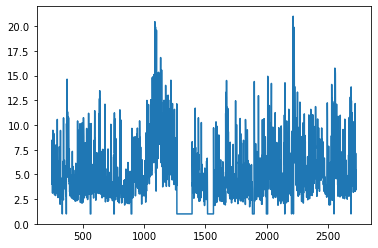

In [88]:
plt.plot(pd.Series(data.values[0,:,2]+1))

In [140]:
file_path = r'datasets/Astock_daily_2011_2022.parquet.gzip'
data_a = pd.read_parquet(file_path)

In [15]:
# data_xarray = data_a.loc[:,['close','high','low','open','close_rate']].to_xarray()

# import xarray as xr

# data_xarray.columns

# data_a = xr.DataArray(data_a) #***

# data_a = data_a.unstack()

# xr.DataArray(data_a, [data_a.columns, data_a.index.levels[0], data_a.index.levels[1]])
# data_a = data_a.to_xarray().to_array(dim='feature')

In [ ]:
data_a

In [30]:
data_a = data_a.to_xarray().to_array(dim='holcv')

In [ ]:
 dt_embed = _get_time_features(data.index)  # 设置日期特征

In [14]:
pd.to_datetime(data_a.date.values)

DatetimeIndex(['2011-01-04', '2011-01-05', '2011-01-06', '2011-01-07',
               '2011-01-10', '2011-01-11', '2011-01-12', '2011-01-13',
               '2011-01-14', '2011-01-17',
               ...
               '2022-03-21', '2022-03-22', '2022-03-23', '2022-03-24',
               '2022-03-25', '2022-03-28', '2022-03-29', '2022-03-30',
               '2022-03-31', '2022-04-01'],
              dtype='datetime64[ns]', length=2734, freq=None)

In [16]:
_get_time_features(pd.to_datetime(data_a.date.values)).shape

D:\Program Files (x86)\Anaconda\envs\py37\lib\site-packages\ipykernel_launcher.py:133: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


(2734, 7)

In [51]:
data_a.shape[1]

2734

In [ ]:
# (1, 2490, 14)

In [37]:
data_a = data_a.transpose('code','date','holcv')

<xarray.DataArray (code: 4358, date: 2734, holcv: 16)>
array([[[3.35660000e+00, 1.59777000e+01, 1.60200000e+01, ...,
         5.73343724e+08, 1.15550000e+00, 3.58840610e+07],
        [1.37330000e+00, 1.59970000e+01, 1.59300000e+01, ...,
         3.79869071e+08, 7.64700000e-01, 2.37462630e+07],
        [2.38540000e+00, 1.58402000e+01, 1.58100000e+01, ...,
         3.27148853e+08, 6.65100000e-01, 2.06531270e+07],
        ...,
        [3.47410000e+00, 1.50358000e+01, 1.52100000e+01, ...,
         1.85961704e+09, 6.37300000e-01, 1.23679155e+08],
        [3.35310000e+00, 1.53746000e+01, 1.53800000e+01, ...,
         1.78920995e+09, 5.99700000e-01, 1.16374674e+08],
        [3.83620000e+00, 1.56216000e+01, 1.57500000e+01, ...,
         2.31961686e+09, 7.65200000e-01, 1.48487874e+08]],

       [[9.12410000e+00, 8.71570000e+00, 8.80000000e+00, ...,
         1.64566710e+09, 1.95540000e+00, 1.88816123e+08],
        [3.97730000e+00, 8.85840000e+00, 8.83000000e+00, ...,
         1.11275905e+09, 1.30090000e+00, 1.25616280e+08],
        [3.28430000e+00, 8.84890000e+00, 8.84000000e+00, ...,
         7.00203401e+08, 8.19500000e-01, 7.91284460e+07],
...
        [9.74900000e-01, 4.64547000e+01, 4.66000000e+01, ...,
         4.25294340e+08, 4.89300000e-01, 9.15502500e+06],
        [1.95280000e+00, 4.65014000e+01, 4.60900000e+01, ...,
         5.91977029e+08, 6.80400000e-01, 1.27303070e+07],
        [1.54050000e+00, 4.56784000e+01, 4.57100000e+01, ...,
         5.45520358e+08, 6.38300000e-01, 1.19426370e+07]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [3.61340000e+00, 4.41869000e+01, 4.41000000e+01, ...,
         5.71243860e+07, 2.65700000e-01, 1.29279100e+06],
        [2.47170000e+00, 4.38019000e+01, 4.37900000e+01, ...,
         1.81226280e+07, 8.13000000e-02, 4.13741000e+05],
        [3.28840000e+00, 4.32510000e+01, 4.33900000e+01, ...,
         4.31831340e+07, 1.96200000e-01, 9.98430000e+05]]])
Coordinates:
  * date     (date) datetime64[ns] 2011-01-04 2011-01-05 ... 2022-04-01
  * code     (code) object '000001.SZ' '000002.SZ' ... '688981.SH' '689009.SH'
  * holcv    (holcv) <U13 'amp_rate' 'avg_price' ... 'turnover_rate' 'volume'

In [22]:
data  = pd.read_csv(f'datasets/single_stocks_dataset_ratio.csv', parse_dates=True, index_col='date')

In [24]:
dt_embed = _get_time_features(data.index)  # 设置日期特征

D:\Program Files (x86)\Anaconda\envs\py37\lib\site-packages\ipykernel_launcher.py:133: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


In [69]:
xr.DataArray(data_a, [data_a.columns, data_a.index.levels[0], data_a.index.levels[1]])

ValueError: coords is not dict-like, but it has 3 items, which does not match the 2 dimensions of the data

# 单资产训练及下游预测任务

In [1]:
from ts2vec import TS2Vec
import datautils
import pandas as pd
import numpy as np

#### 读取UEA\UCR文件

In [2]:
# from scipy.io import arff
# def read_arrf(file):
#     with open(file, encoding='utf-8') as f:
#         header = []
#         for line in f :
#             if line.startswith('@attribute'):
#                 header.append(line.split()[1])
#             elif line.startswith('@data'):
#                 break
#         df = pd.read_csv(f, header=None)
#         df.columns = header
#     return df
# data= pd.DataFrame(arff.loadarff(r'D:\home\GitHub\ts2vec\datasets\UEA\Epilepsy\EpilepsyDimension3_TRAIN.arff')[0])
# raw = pd.read_csv(r'D:\home\GitHub\ts2vec\datasets\UCR\ArrowHead\ArrowHead_TRAIN.tsv',sep='\t')


#### 数据集加载

In [3]:
data, train_slice, valid_slice, test_slice, scaler, pred_lens, n_covariate_cols = datautils.load_forecast_csv('single_stocks_dataset_300203')

D:\home\work\seafile_root\王彦龙\我的资料库\私人资料库\GitHub\ts2vec\datautils.py:133: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  dt.weekofyear.to_numpy(),


#### 模型加载

In [4]:
import torch
torch.Tensor([[1,2],[2,3]]).shape

torch.Size([2, 2])

In [5]:
model = TS2Vec(
    input_dims=data.shape[2],
    device='cuda',
    output_dims=256,
    max_train_length=900,
    hidden_dims=64,
    depth=12,
    batch_size=60,
)

#### 模型训练

In [10]:
data[train_slice].shape

(1, 2490, 14)

In [8]:
loss_log = model.fit(
    data[train_slice],
    n_epochs = 600,
    n_iters = 2000,
    verbose=True
)

loss: tensor(0.3602, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #200: loss=0.3602256178855896
loss: tensor(0.5577, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #201: loss=0.5577016472816467
loss: tensor(0.5543, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #202: loss=0.5542883276939392
loss: tensor(0.5520, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #203: loss=0.5519691109657288
loss: tensor(0.5433, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #204: loss=0.5433019995689392
loss: tensor(0.5479, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #205: loss=0.5478593707084656
loss: tensor(0.4442, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #206: loss=0.4441501796245575
loss: tensor(0.5947, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #207: loss=0.5947218537330627
loss: tensor(0.6284, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #208: loss=0.6283891797065735
loss: tensor(0.5146, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #209: loss=0.5145692825317383
loss: tensor(0.5409,

loss: tensor(0.2575, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #285: loss=0.2575462758541107
loss: tensor(0.2887, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #286: loss=0.28874751925468445
loss: tensor(0.3040, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #287: loss=0.3040262758731842
loss: tensor(0.2468, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #288: loss=0.24675285816192627
loss: tensor(0.2686, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #289: loss=0.26860034465789795
loss: tensor(0.3328, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #290: loss=0.332829087972641
loss: tensor(0.2176, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #291: loss=0.21760275959968567
loss: tensor(0.3289, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #292: loss=0.3288704454898834
loss: tensor(0.3135, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #293: loss=0.3135218918323517
loss: tensor(0.2557, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #294: loss=0.2556878626346588
loss: tensor(0.26

loss: tensor(0.3195, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #370: loss=0.31953755021095276
loss: tensor(0.3785, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #371: loss=0.3785105049610138
loss: tensor(0.2660, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #372: loss=0.2659507691860199
loss: tensor(0.2187, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #373: loss=0.2187013179063797
loss: tensor(0.2912, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #374: loss=0.291217178106308
loss: tensor(0.2863, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #375: loss=0.2863008677959442
loss: tensor(0.4076, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #376: loss=0.4075625240802765
loss: tensor(0.2248, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #377: loss=0.22479906678199768
loss: tensor(0.3253, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #378: loss=0.3252551555633545
loss: tensor(0.2601, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #379: loss=0.26007604598999023
loss: tensor(0.332

loss: tensor(0.0821, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #453: loss=0.08210042119026184
loss: tensor(0.0569, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #454: loss=0.05686578154563904
loss: tensor(0.1038, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #455: loss=0.10376548767089844
loss: tensor(0.0833, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #456: loss=0.08326848596334457
loss: tensor(0.2283, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #457: loss=0.22825950384140015
loss: tensor(0.0610, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #458: loss=0.06100152060389519
loss: tensor(0.1347, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #459: loss=0.1347118616104126
loss: tensor(0.0798, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #460: loss=0.07977154850959778
loss: tensor(0.1294, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #461: loss=0.12937521934509277
loss: tensor(0.0913, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #462: loss=0.09132545441389084
loss: tenso

loss: tensor(0.0717, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #537: loss=0.07168739289045334
loss: tensor(0.0542, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #538: loss=0.0541803240776062
loss: tensor(0.0689, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #539: loss=0.06889594346284866
loss: tensor(0.0651, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #540: loss=0.06513218581676483
loss: tensor(0.1295, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #541: loss=0.12948544323444366
loss: tensor(0.0387, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #542: loss=0.03868334740400314
loss: tensor(0.0446, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #543: loss=0.044627703726291656
loss: tensor(0.4802, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #544: loss=0.48015958070755005
loss: tensor(0.0456, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #545: loss=0.04564119502902031
loss: tensor(0.0573, device='cuda:0', grad_fn=<DivBackward0>)
Epoch #546: loss=0.05732331424951553
loss: tens

#### 打印损失图

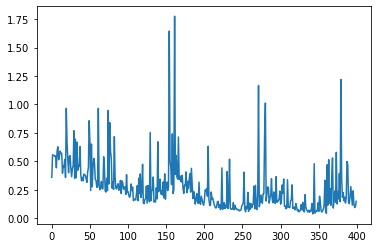

In [9]:
import matplotlib.pyplot as plt
plt.plot(loss_log)
plt.show()

#### 模型保存

In [12]:
model.save(r'examination/single_stocks_dataset_ratio_300203')